In [313]:
import re #regular expressions, used for searching strings in a systematic way
import cv2 #allows you to work with 
import plotly #basic image analysis/manipulation
import plotly.graph_objects as go #interavtive graphing
import numpy as np #array manipulation
import seaborn as sns #graphing tool
import matplotlib.pyplot as plt #graphing tool
from scipy.optimize import curve_fit #stats/data analysis
import math #bacis math functions

In [314]:
#import helper functions 
from muser_mem_imaging_helper_functions import *

In [316]:
# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/Muser_2023')
# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/mem_images/2023_07_19_N2APz1KO_5.asc')
# df_ephys=load_dataframe('C:/Users/mjs164/Box Sync/muser_project/2023_07_24_N2APz1KO_42.asc')
# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/fire_polished_creep_expt/ascii_files/2023_09_01_fpnorm_26.asc')
# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/MDFI_expt/ascii_files/2023_12_11_hPz1_hMDFI_2.asc')
# df_ephys=load_dataframe('D:/Pz2_tension_data_from_work/ascii_with_images/2024_01_11_n2aPz1KO_pz1_pz2_tension_21.asc')

date='2025_04_19'
patch_num='4'

# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/Pz1_Pz2_splice_expt/2024/ascii_no_images/need_to_analyze/'+date+'_n2aPz1KO_pz1_pz2_tension_'+patch_num+'.asc')

# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/hPz1.1_expt/p50_ascii_current/'+date+'_n2aPz1KO_pz1_pz2_tension_'+patch_num+'.asc')


df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/Pz1_Pz2_splice_expt/2025/ascii_with_images/'+date+'_pz2_tension_'+patch_num+'.asc')

# df_ephys=load_dataframe('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/Pz1_Pz2_splice_expt/2024/ascii_with_images/'+date+'_n2aPz1KO_pz1_pz2_tension_'+patch_num+'.asc')

In [317]:
#finding max currents
df_summary, max_fig = max_currents(df_ephys)
max_fig.show()
bad_max_current_sweeps = create_checkbox_list(df_ephys)

max current larger than average max current: 0
max current larger than average max current: 1
max current larger than average max current: 2


In [272]:
##### call traces that are problematic/need to be checked and plot them
problem_trace_fig = problem_traces_fig(df_ephys, bad_max_current_sweeps)
avg_max_current_list=df_summary['max_current'].tolist()
abs_max_current_list=df_summary['abs_max_current'].tolist()

In [273]:
##### go through each trace and input ranges for finding max that avoid the noise and return the correct max current list
avg_max_current_list, abs_max_current_list = fix_problem_trace(df_ephys, avg_max_current_list, abs_max_current_list, bad_max_current_sweeps)
df_summary['max_current'], df_summary['abs_max_current']=avg_max_current_list, abs_max_current_list

Ranges for sweep number 7
x lower limit value: 5003
x upper limit value: 5010




In [260]:
# # #if you need tocut last sweep
cutoff_sweep=16
df_summary=df_summary.loc[df_summary['sweep']<cutoff_sweep]

# remove_sweep=6
# df_summary=df_summary.loc[df_summary['sweep']!=remove_sweep]

Text(0.5, 0, 'Pressure (mmHg)')

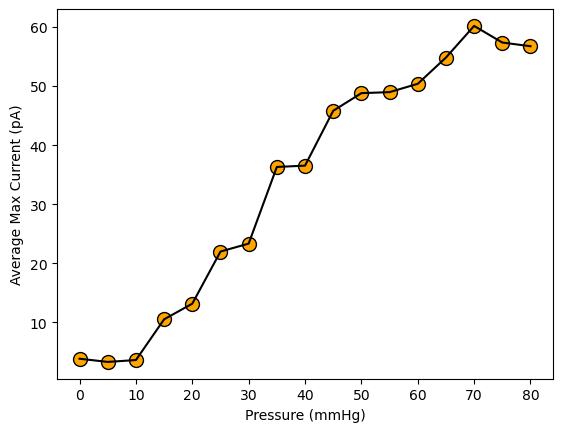

In [318]:
#plot a max average current v pressure graph using the data from the df_summary dataframe
plt.scatter(df_summary['pressure'], df_summary['max_current'], color='orange', s=100, edgecolor='black') #graph scatter plot
plt.plot(df_summary['pressure'], df_summary['max_current'], color='black') #graph overlapping line plot
plt.ylabel('Average Max Current (pA)') #add y axis title
plt.xlabel('Pressure (mmHg)') #add x axis title

Text(0.5, 0, 'Pressure (mmHg)')

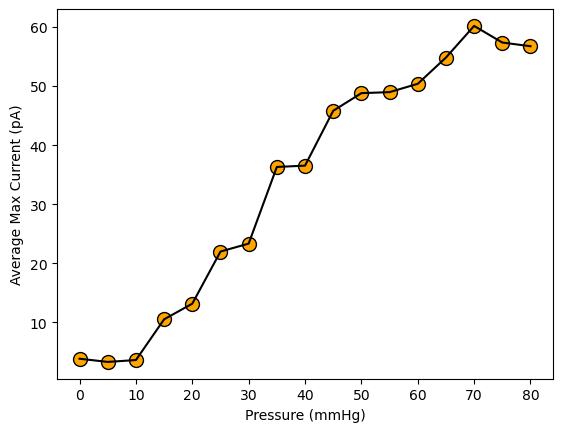

In [319]:
#correcting dataframe for rundown
df_summary=fix_rundown(df_summary)

#plot a max average current v pressure graph using the data from the df_summary dataframe
plt.scatter(df_summary['pressure'], df_summary['max_current'], color='orange', s=100, edgecolor='black') #graph scatter plot
plt.plot(df_summary['pressure'], df_summary['max_current'], color='black') #graph overlapping line plot
plt.ylabel('Average Max Current (pA)') #add y axis title
plt.xlabel('Pressure (mmHg)') #add x axis title

In [320]:
# df_summary=df_summary.loc[df_summary['pressure']<70]

In [321]:

def generate_p50_nonnorm(df_summary):
    '''Takes the summary df generated originally from the max_currents function and performs a P50 fit on the non-normalized data. The fit is constrained to +/-30pA of the max current.
     This data, along with the max current determined by the plateau of the fit, are then added to the summary dataframe (df_summary).
     
     Inputs:
        -df_summary: summary dataframe originally generated from the max_currents function.

    Outputs:
        -df_summary: updated version of the inpur df_summary that now contains a p50 and p50_max_current column'''
    #doing all of this first for the average max current values 
    p50_avg_max_current_list=[]

    #setting arbitrary upper and lower bounds to the fit is not constrained but its close to where the true plateau should be
    amin = df_summary['max_current'].max()-20
    amax = df_summary['max_current'].max()+20
    popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['max_current'], p0=[50,40,1])
#     popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['max_current'], p0=[200,20,1],
#                            bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))

    #adding p50 and max from p50 values to respective lists with the same length as the number of pressure steps for that patch
    for i in range(len(df_summary)):
        p50_avg_max_current_list.append(popt[0])

    #updating the summary dataframe to contain the p50 and max current determined by the plateau of the p50 fit
    df_summary['p50_avg_max_current'] = p50_avg_max_current_list


    #plotting the data as a visual check that the fit is reasonable
    xdata_gen = np.linspace(0, df_summary['pressure'].max(), 500)
    ydata_gen = fit_boltz(xdata_gen, *popt)
    print('Plateau value from Boltzman Fit: ', popt[0], 'pA')
    plt.scatter(df_summary['pressure'], df_summary['max_current'], color='lightslategrey',s=70, edgecolors='black')
    plt.plot(xdata_gen, ydata_gen, linewidth=5, color='tomato')
    plt.show()

    #repeating this process for the mabolute max current values
    p50_abs_max_current_list=[]

    #setting arbitrary upper and lower bounds to the fit is not constrained but its close to where the true plateau should be
    amin = df_summary['abs_max_current'].max()-60
    amax = df_summary['abs_max_current'].max()+60
    popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['abs_max_current'],  p0=[50,40,1],
                           bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))
    
    #adding p50 and max from p50 values to respective lists with the same length as the number of pressure steps for that patch
    for i in range(len(df_summary)):
        p50_abs_max_current_list.append(popt[0])

    #updating the summary dataframe to contain the p50 and max current determined by the plateau of the p50 fit
    df_summary['p50_abs_max_current'] = p50_abs_max_current_list

    return df_summary

Plateau value from Boltzman Fit:  57.82635576883592 pA


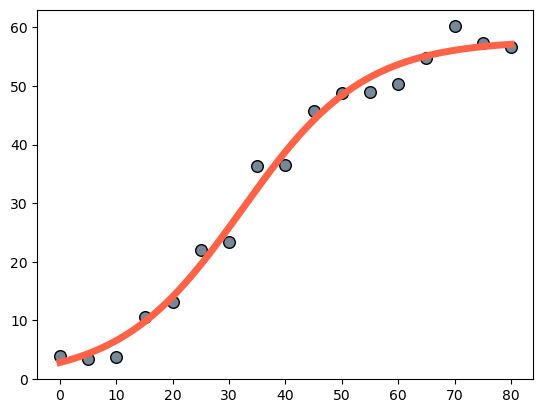

In [322]:
df_summary=generate_p50_nonnorm(df_summary)

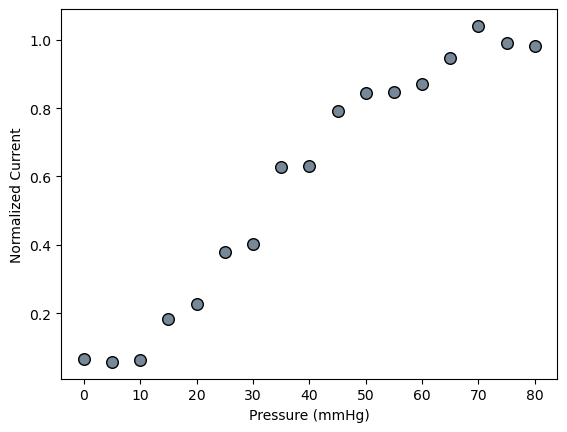

In [323]:
df_summary=generate_norm_current(df_summary)

In [324]:
# def generate_p50_norm(df_summary):
#     '''Takes the summary df generated originally from the max_currents function and performs a P50 fit on the normalized data. The fit is constrained to +/-30pA of the max current.
#      This data, along with the max current determined by the plateau of the fit, are then added to the summary dataframe (df_summary).
     
#      Inputs:
#         -df_summary: summary dataframe originally generated from the max_currents function.

#     Outputs:
#         -df_summary: updated version of the inpur df_summary that now contains a p50 and p50_max_current column'''
    
#     #doing all of this first for the average max current values 
#     p50_list_avgm=[]
#     k_avgm_slope_list=[]
#     #setting arbitrary upper and lower bounds to the fit is not constrained but its close to where the true plateau should be
#     amin = df_summary['avg_norm_current'].max()-0.1
#     amax = df_summary['avg_norm_current'].max()+0.1
#     popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['avg_norm_current'], p0=[1,2,1])
#     print(popt)

#     #adding p50 and max from p50 values to respective lists with the same length as the number of pressure steps for that patch
#     for i in range(len(df_summary)):
#         p50_list_avgm.append(popt[1])
#         k_avgm_slope_list.append(popt[2])

#     #updating the summary dataframe to contain the p50 and max current determined by the plateau of the p50 fit
#     df_summary['p50_avgm'] = p50_list_avgm
#     df_summary['k_avgm_slope'] = k_avgm_slope_list

#     #plotting the data as a visual check that the fit is reasonable
#     xdata_gen = np.linspace(0, df_summary['pressure'].max(), 500)
#     ydata_gen = fit_boltz(xdata_gen, *popt)
#     print('P50 value from Boltzman Fit: ', popt[1], 'mmHg')
#     print('k value from Boltzman Fit: ', popt[2])
    
#     #plotting P50
#     plt.scatter(df_summary['pressure'], df_summary['avg_norm_current'], color='orange',s=70, edgecolors='black', zorder=3)
#     plt.plot(xdata_gen, ydata_gen, linewidth=5, color='blue', zorder=2)

#     #plotting lines to show P50 value
#     plt.plot([0, popt[1]], [0.5, 0.5], linewidth=5, color='red', linestyle='dotted', zorder=1)
#     plt.plot([popt[1], popt[1]], [0, 0.5], linewidth=5, color='red', linestyle='dotted', zorder=1)
#     plt.scatter(popt[1], 0.5, color='red', s=100, edgecolors='black', zorder=4)
#     plt.ylabel('Normalized Current') #add y axis title
#     plt.xlabel('Pressure (mmHg)') #add x axis title
#     plt.show()

#     #repeating this process for the mabolute max current values
#     p50_list_absm=[]
#     k_absm_slope_list=[]

#     #setting arbitrary upper and lower bounds to the fit is not constrained but its close to where the true plateau should be
#     amin = df_summary['abs_norm_current'].max()-0.1
#     amax = df_summary['abs_norm_current'].max()+0.1
#     popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['abs_norm_current'],
#                            bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))
    
#     #adding p50 and max from p50 values to respective lists with the same length as the number of pressure steps for that patch
#     for i in range(len(df_summary)):
#         p50_list_absm.append(popt[1])
#         k_absm_slope_list.append(popt[2])

#     #updating the summary dataframe to contain the p50 and max current determined by the plateau of the p50 fit
#     df_summary['p50_absm'] = p50_list_absm
#     df_summary['k_absm_slope'] = k_absm_slope_list

#     return df_summary

[ 0.99999993 32.2906001   0.09240104]
P50 value from Boltzman Fit:  32.290600095275636 mmHg
k value from Boltzman Fit:  0.0924010384493172


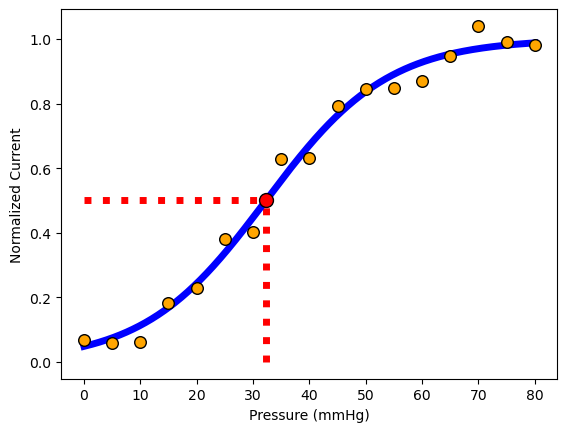

In [325]:
df_summary=generate_p50_norm(df_summary)

In [326]:
df_summary=steady_state_currents(df_ephys, df_summary)
df_summary.insert(0,'date',[date]*len(df_summary))
df_summary.insert(1,'patch_num',[patch_num]*len(df_summary))
df_summary.insert(2,'none',[None]*len(df_summary))

df_summary.to_clipboard(index=False, header=False)

df_summary

date patch_num  none  sweep  pressure  max_current  abs_max_current  \
0   2025_04_19         4  None      0         0     3.870741         4.949647   
1   2025_04_19         4  None      1         5     3.328064         4.835268   
2   2025_04_19         4  None      2        10     3.646745         5.175470   
3   2025_04_19         4  None      3        15    10.536974        12.157535   
4   2025_04_19         4  None      4        20    13.184356        14.642169   
5   2025_04_19         4  None      5        25    22.000389        23.515622   
6   2025_04_19         4  None      6        30    23.342972        25.217438   
7   2025_04_19         4  None      7        35    36.309056        38.125648   
8   2025_04_19         4  None      8        40    36.532881        39.064436   
9   2025_04_19         4  None      9        45    45.812164        47.655994   
10  2025_04_19         4  None     10        50    48.795985        50.709496   
11  2025_04_19         4  None     11        55    48.966793        50.341748   
12  2025_04_19         4  None     12        60    50.376411        52.527635   
13  2025_04_19         4  None     13        65    54.816308        56.660811   
14  2025_04_19         4  None     14        70    60.167614        61.198137   
15  2025_04_19         4  None     15        75    57.356752        61.649436   
16  2025_04_19         4  None     16        80    56.731840        58.489984   

    p50_avg_max_current  p50_abs_max_current  avg_norm_current  \
0             57.826356            60.434431          0.066937   
1             57.826356            60.434431          0.057553   
2             57.826356            60.434431          0.063064   
3             57.826356            60.434431          0.182217   
4             57.826356            60.434431          0.227999   
5             57.826356            60.434431          0.380456   
6             57.826356            60.434431          0.403674   
7             57.826356            60.434431          0.627898   
8             57.826356            60.434431          0.631769   
9             57.826356            60.434431          0.792237   
10            57.826356            60.434431          0.843836   
11            57.826356            60.434431          0.846790   
12            57.826356            60.434431          0.871167   
13            57.826356            60.434431          0.947947   
14            57.826356            60.434431          1.040488   
15            57.826356            60.434431          0.991879   
16            57.826356            60.434431          0.981072   

    abs_norm_current  p50_avgm  k_avgm_slope   p50_absm  k_absm_slope  \
0           0.081901   32.2906      0.092401  31.822779      0.087336   
1           0.080008   32.2906      0.092401  31.822779      0.087336   
2           0.085638   32.2906      0.092401  31.822779      0.087336   
3           0.201169   32.2906      0.092401  31.822779      0.087336   
4           0.242282   32.2906      0.092401  31.822779      0.087336   
5           0.389110   32.2906      0.092401  31.822779      0.087336   
6           0.417269   32.2906      0.092401  31.822779      0.087336   
7           0.630860   32.2906      0.092401  31.822779      0.087336   
8           0.646394   32.2906      0.092401  31.822779      0.087336   
9           0.788557   32.2906      0.092401  31.822779      0.087336   
10          0.839083   32.2906      0.092401  31.822779      0.087336   
11          0.832998   32.2906      0.092401  31.822779      0.087336   
12          0.869167   32.2906      0.092401  31.822779      0.087336   
13          0.937558   32.2906      0.092401  31.822779      0.087336   
14          1.012637   32.2906      0.092401  31.822779      0.087336   
15          1.020105   32.2906      0.092401  31.822779      0.087336   
16          0.967825   32.2906      0.092401  31.822779      0.087336   

      ssc_raw  ssc_norm  
0   -0.792568 -0.2047

In [327]:
df_summary.to_clipboard(index=False, header=False)
